In [61]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack


Variable initialization

In [62]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

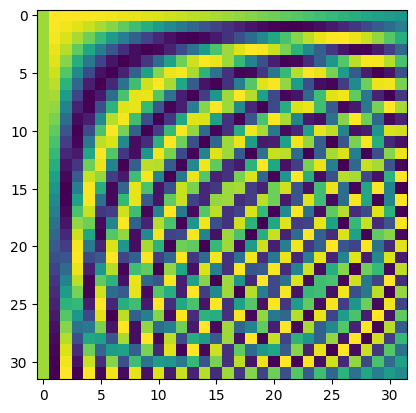

In [63]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    DCT[:, i] = scipy.fftpack.idct(a, norm="ortho")
plt.imshow(DCT)
plt.show()

Generating the 1-D standard basis

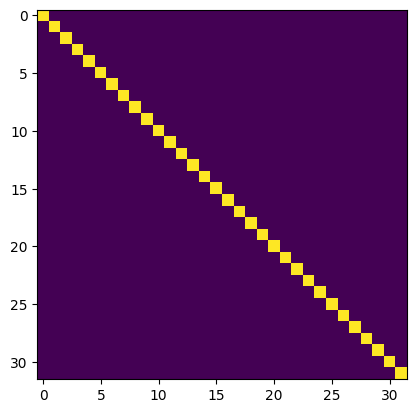

In [64]:
for i in range(M):
    # C[:, i] = 
    pass
C = np.eye(M)
plt.imshow(C)
plt.show()

Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

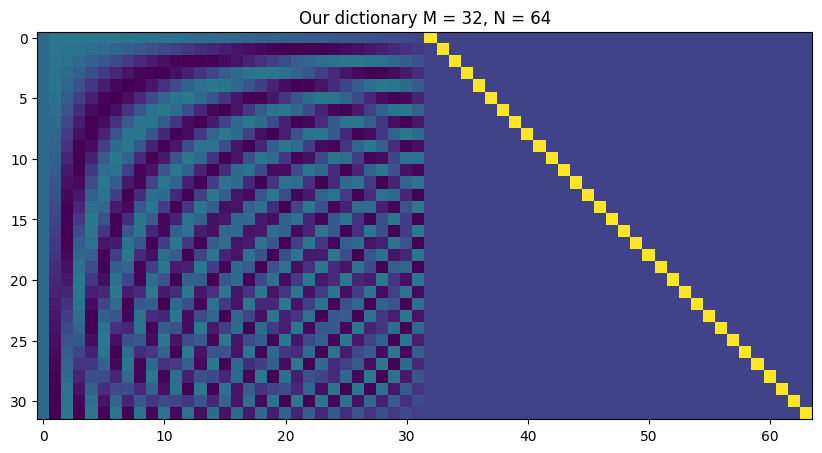

In [65]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [66]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [67]:
# Number of non zero coeffitients
K = 5

In [68]:
x0 = np.zeros(M)
nonzero_coeffs = np.random.choice(M, K)
x0[nonzero_coeffs] = np.random.random(K)
x0

array([0.        , 0.        , 0.        , 0.31025048, 0.        ,
       0.29553095, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.80816003, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.24731302, 0.        , 0.        , 0.        , 0.        ,
       0.78675287, 0.        ])



Choose spike location and update x0

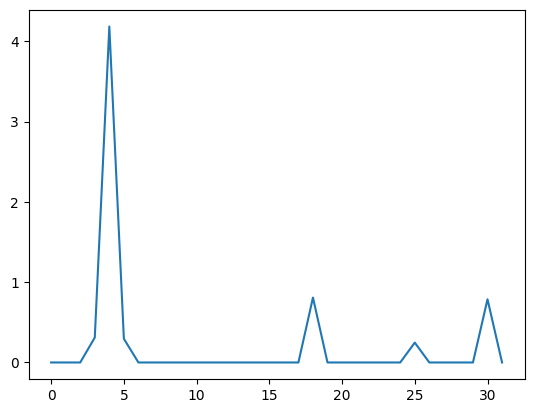

In [69]:
spikeLocation = 4
x0[spikeLocation] = np.random.rand() * 10
plt.plot(x0)
plt.show()

Synthetize the corresponding signal in the signal domain and add noise


In [70]:
s0 = np.dot(DCT, x0)
s = s0 + sigma_noise

Plot the sparse signal

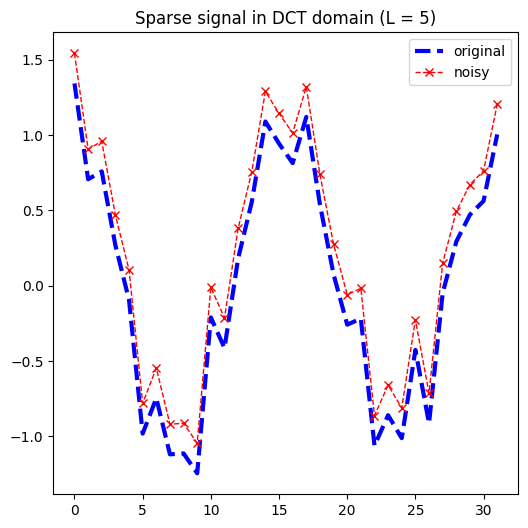

In [71]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [72]:
x_MP = np.zeros(N)

r = s

l = 1

#initialize the norm of the resiudal (components not represented by the coefficients)

resNorm = np.linalg.norm(r)
print(resNorm)

MINIMUM_RES_NORM = 0.1


4.505905579862418


MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [ ]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    eps = np.zeros(N)
    z = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        # Epsilon j is the distance between the dj vector and the r vector
        eps[j] = np.linalg.norm(r) - np.dot(r.T, dj)**2 / np.linalg.norm(dj)
        z[j] = np.dot(r.T, dj)
        # here we had some annotation clash, so I renamed e with eps for more clarity
        # this corresponds to solving e(j) = min( || dj zj - s ||),
        # which is obtained by setting zj = dj' r / || dj ||^2 (analytically defined)
        # there is no need to divide by || dj ||^2 since columns are nomalized
        # so here zj is the projection of the residual on the jth column of the dictionary

    # find the column of D that matches at best r, i.e. jStar = argmin(eps(j))
    jStar = np.argmin(eps)

    # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
    # e is the canonical basis of jStar (element on jStar idx set to 1)
    e_jStar = np.zeros(N)
    e_jStar[jStar] = 1
    x_MP = x_MP + z * e_jStar

    # remove the signal we have so far represented in coeff_MP (update the residual)
    r = s - np.dot(D, x_MP) # component that cannot be captured by the signal (the signal at the very beginning)

    l = l + 1

    # update the residual norm
    resNorm = np.linalg.norm(r)
    
print(f"Non zero components: {np.count_nonzero(x_MP)}")
print(f"N: {x_MP.shape}")

Non zero components: 5
N: (64,)


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [74]:
s_hat_MP = np.dot(D, x_MP)

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [75]:
resNorm_MP = np.linalg.norm(s_hat_MP)
resNorm_MP

np.float64(4.489396710360321)

Show the result

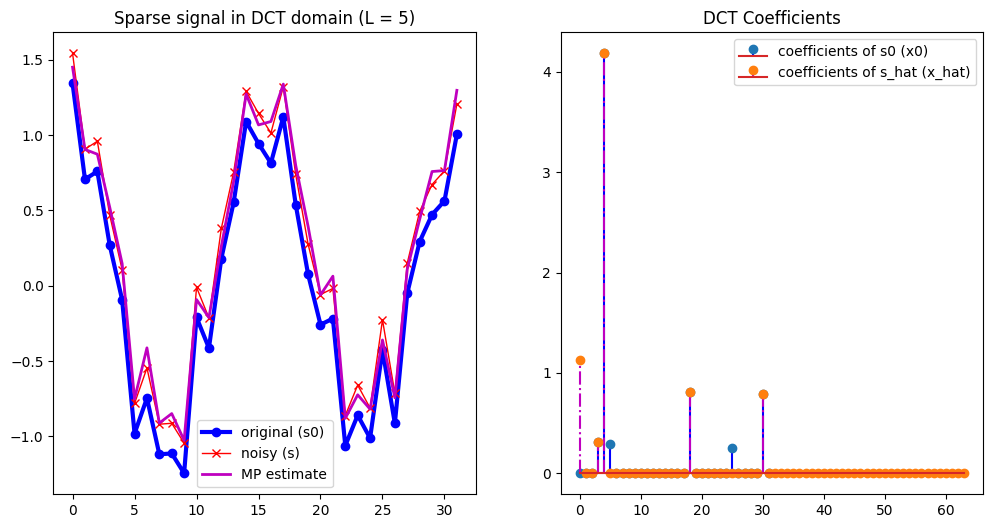

In [76]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

